1. Tham khảo các bước

   Mô hình CNN: https://www.kaggle.com/code/yassineghouzam/introduction-to-cnn-keras-0-997-top-6

   Kĩ thuật deskew: https://stackoverflow.com/questions/43577665/deskew-mnist-images

   Dùng nội suy INTER_AREA VÌ: https://stackoverflow.com/questions/23853632/which-kind-of-interpolation-best-for-resizing-image

   Làm ảnh sắc nét hơn với phương pháp của người thứ 2: https://stackoverflow.com/questions/4993082/how-can-i-sharpen-an-image-in-opencv

2. Dữ liệu đóng góp
  tổng cộng đóng góp 9 số từ 0->9 với mỗi số gồm 3 sample cho mỗi link:
  
      https://github.com/truong04/CS114.O21/tree/main/LAB01/data/22521575

      https://github.com/truong04/CS114.O21/tree/main/LAB01/data/22520125

      https://github.com/TruongSon421/CS114.O21/tree/main/LAB01/data/22521204

      https://github.com/TruongSon421/CS114.O21/tree/main/LAB01/data/22521260

      Tổng cộng là 120 mẫu




3. Đặc trưng và thuật toán học

   Sử dụng các lớp Convolutional Layers để trích xuất các đặc trưng của số như

   chi tiết thẳng đứng của số 1 hay nằm ngang của số 5

   Thêm các lớp drop out để tránh bị overfit với tập data MNIST

   MaxPooling giữ lại các đặc trưng quan trọng khi ảnh giảm kích thước ảnh
   
   Lớp dense kết hợp các đặc trưng lại và phân loại

In [1]:
import cv2
import numpy as np
from numpy import mean
from numpy import std
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from numpy import argmax
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model
import copy
import os
from google.colab.patches import cv2_imshow

In [2]:
from scipy.ndimage import affine_transform
from scipy.ndimage import interpolation

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
model = load_model('/content/drive/MyDrive/model_fruit/bao/model_6.h5')

In [5]:
from numpy import mean
from numpy import std
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.optimizers import SGD
from numpy import argmax
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model

In [8]:
def define_model():
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='Same',
                     activation='relu', input_shape=(28, 28, 1)))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='Same',
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='Same',
                     activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='Same',
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))

    model.add(Dense(10, activation='softmax'))

    # Compile model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [9]:
a = define_model()
print(a.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        36928     
                                                        

In [ ]:
def moments(image):
    c0, c1 = np.mgrid[:image.shape[0], :image.shape[1]]
    totalImage = np.sum(image)  # sum of pixels
    m0 = np.sum(c0 * image) / totalImage
    m1 = np.sum(c1 * image) / totalImage
    m00 = np.sum((c0 - m0) ** 2 * image) / totalImage
    m11 = np.sum((c1 - m1) ** 2 * image) / totalImage
    m01 = np.sum((c0 - m0) * (c1 - m1) * image) / totalImage
    mu_vector = np.array([m0, m1])
    covariance_matrix = np.array([[m00, m01], [m01, m11]])
    return mu_vector, covariance_matrix

def deskew(image):
    c, v = moments(image)
    alpha = v[0, 1] / v[0, 0]
    affine = np.array([[1, 0], [alpha, 1]])
    ocenter = np.array(image.shape) / 2.0
    offset = c - np.dot(affine, ocenter)
    return affine_transform(image, affine, offset=offset)

In [ ]:
def run_example(path):
  try:
        image = cv2.imread(path)

        inputImageCopy = image.copy()
        grayscaleImage = cv2.cvtColor(inputImageCopy, cv2.COLOR_BGR2GRAY)
        threshValue, binaryImage = cv2.threshold(grayscaleImage, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
        img_resize1 = deskew(binaryImage)
        #kĩ thuật deskew: https://stackoverflow.com/questions/43577665/deskew-mnist-images
        gray = cv2.resize(img_resize1, (28, 28), interpolation=cv2.INTER_AREA)
        #tại sao lại dùng nội suy INTER_AREA VÌ: https://stackoverflow.com/questions/23853632/which-kind-of-interpolation-best-for-resizing-image

        sharpen_kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
        sharpen_img = cv2.filter2D(gray, -1, sharpen_kernel)
        #làm ảnh sắc nét hơn với phương pháp của người thứ 2: https://stackoverflow.com/questions/4993082/how-can-i-sharpen-an-image-in-opencv

        sharpen_img = sharpen_img.astype('float32')
        sharpen_img = sharpen_img / 255.0

        # plt.imshow(sharpen_img, cmap='gray')
        # plt.show()

        image_file = np.array(sharpen_img)
        prediction = model.predict(image_file.reshape(1, 28, 28, 1))
        digit = argmax(prediction)
        return digit
  except:
    return 0

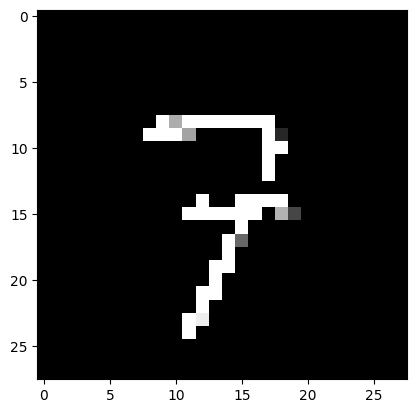

0

In [ ]:
path = "/content/drive/MyDrive/data/handtest/00165d6f69c3be0eeb5d6d25c178daae  -.png"
run_example(path)

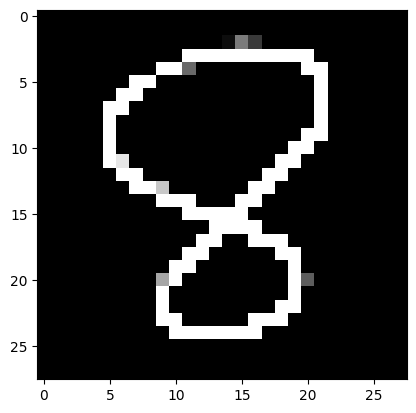

0

In [ ]:
path = "/content/drive/MyDrive/data/handtest/01d17245e19ba308bfef89dfafa17e4c  -.jpg"
run_example(path)

In [ ]:
path = "/content/drive/MyDrive/data/handtest/01d17245e19ba308bfef89dfafa17e4c  -.jpg"
run_example(path)

In [ ]:
results = []
org_dir = "/content/drive/MyDrive/data/handtest"

for item in os.listdir(org_dir):
    dir1 = os.path.join(org_dir, item)
    digit = run_example(dir1)
    results.append([item, digit])

1/1 [==============================] - 0s 21ms/step


In [ ]:
import pandas as pd


# Chuyển danh sách kết quả thành DataFrame
df = pd.DataFrame(results, columns=['file_name', 'label'])

# Lưu DataFrame thành file CSV
df.to_csv('output22.csv', index=False, header=False)